In [1]:
import os
import warnings
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed 
from sklearn import ensemble, linear_model, svm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from test_diff_models import *
from success_utils import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create a dictionary to group countries by region
region_groups = {
    "North America": ["HI", "Mexico", "NV", "OK", "NM","CA", "NY", "MD", "DC", "WA", "CO", "MN", "TX", "SC", "GA", "KY", "PA", "MI", "OH", "OR", "NC", "IL", "AZ", "TN", "NJ", "UT", "VA", "ND", "VT", "IA", "ND", "VT", "LA", "CT", "RI"],
    "Europe": ["Martinique", "AL", "Cayman Islands", "Russia", "ME", "UK", "DE", "Poland", "Denmark", "Netherlands", "Norway", "Liechtenstein", "Austria", "Belgium", "Czech Republic", "Iceland", "Ireland", "France", "Spain", "Sweden", "Switzerland", "Italy", "Slovenia", "Greece"],
    "Asia": ["MO", "IN", "Japan", "China", "Hong Kong", "India", "Viet Nam", "Taiwan", "Afghanistan", "Israel","Sri Lanka", "Jordan"],
    "South America": ["Colombia", "Brazil"],
    "Africa": ["WI", "SD", "MA", "Ghana", "Ethiopia", "Liberia", "Rwanda"],
    "Oceania": ["AU", "NZ"],
    "Other": [ "United Arab Emirates", "Svalbard and Jan Mayen"]
}

noticable_entities = ['ORG', 'PERSON', 'DATE',
                        'CARDINAL', 'GPE', 'PRODUCT', 
                        'WORK_OF_ART','ORDINAL', 'MONEY',
                        'TIME', 'NORP']


data_path = '/workspaces/Crowdfunding-Social-Media-Drivers/Data/Kickstarter_only/final_data.csv'
success_data = pd.read_csv(data_path)
success_data['collection_ratio'] = success_data.collected.apply(decode_amount)/success_data.goal_amount.apply(decode_amount)


bins = [0, 7, 14, 30, 60]
labels = ['<1 week', '1-2 weeks', '2 weeks - 1 month', '1-2 months']
success_data['duration'] = pd.cut(success_data['duration'], bins=bins, labels=labels)
success_data= success_data[success_data.donate != 1].reset_index(drop=True)


success_weights = (1-success_data.success.value_counts()/len(success_data)).values


def get_region(country):
    for region, countries in region_groups.items():
        if country in countries:
            return region
    return "Other"

success_data['region'] = success_data.country.str.strip().apply(get_region)
success_data.num_backers = success_data.num_backers.str.replace(',', '').astype(int)
success_data = success_data[success_data.region == 'North America']

success_data = pd.get_dummies(
                    success_data,
                    columns=['fb_type', 
                              'duration'])


for entity in noticable_entities:
    success_data[f'fb_entity_{entity}'] = success_data.fb_entities_identified.fillna('None').str.split(',').apply(lambda entity_list: entity in entity_list).astype(int)
    

bool_cols = success_data.dtypes[success_data.dtypes == 'bool'].index.tolist()
success_data[bool_cols] = success_data[bool_cols].astype(int)

#ecoding the number of backers
success_data.num_backers = encode_targets(success_data.num_backers)
success_data.population = np.exp(success_data.population)


success_data.head()

,collected,goal_amount,num_backers,category,pledge_types,donate,project_we_love,success,start_month,start_day,population,country,Person,Team,num_projects,num_backed,verified,fb_page_name,fb_likes_at_posting,fb_followers_at_posting,fb_likes,fb_comments,fb_shares,fb_post_views,fb_readability,fb_readability_lix,fb_entropy_scores,fb_perplexity_scores,fb_fear,fb_anger,fb_anticip,fb_trust,fb_surprise,fb_positive,fb_negative,fb_sadness,fb_disgust,fb_joy,fb_entities_identified,fb_post_sponsored,fb_post_age,fb_page_age,fb_positive_reactions,fb_negative_reactions,fb_topic_0,fb_topic_1,fb_topic_2,fb_topic_3,fb_topic_4,fb_topic_5,fb_topic_6,fb_topic_7,fb_topic_8,fb_topic_9,fb_topic_10,collection_ratio,region,fb_type_link,fb_type_photo,fb_type_video,duration_<1 week,duration_1-2 weeks,duration_2 weeks - 1 month,duration_1-2 months,fb_entity_ORG,fb_entity_PERSON,fb_entity_DATE,fb_entity_CARDINAL,fb_entity_GPE,fb_entity_PRODUCT,fb_entity_WORK_OF_ART,fb_entity_ORDINAL,fb_entity_MONEY,fb_entity_TIME,fb_entity_NORP
2,12.96,10.82,6.82,design,4.00,0.00,1.00,1,6,1,684451.00,WA,0,1,7,16,Marc Barros,Kickstarter,1589901,1588019,10,2,1,12,4.84,33.73,0.72,2.05,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,PRODUCT,0,2,4839,2,0,0.00,0.00,0.00,0.24,0.00,0.00,0.45,0.08,0.09,0.00,0.12,8.51,North America,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,11.87,9.90,6.95,comics,8.00,0.00,1.00,1,6,1,105319.00,CA,1,0,3,88,Adam Lawson,Kickstarter,1589930,1588019,4,1,0,5,6.93,29.11,0.63,1.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"CARDINAL,PERSON",0,8,4839,0,1,0.00,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.12,North America,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
5,10.37,10.31,5.32,film_Video,13.00,0.00,1.00,1,6,1,8175133.00,NY,1,0,1,2,Julia Greenberg,Kickstarter,1589715,1587803,3,1,0,4,15.90,61.67,0.28,1.33,0.29,0.00,0.00,0.00,0.00,0.29,0.14,0.00,0.00,0.14,"PERSON,GPE",0,9,4839,0,1,0.00,0.15,0.00,0.08,0.00,0.13,0.00,0.16,0.29,0.16,0.00,1.07,North America,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
6,9.54,8.80,5.56,comics,16.00,0.00,1.00,1,6,1,3971883.00,CA,0,1,4,23,Donold Wooldridge,Kickstarter,1589715,1587803,3,5,1,5,14.24,45.00,0.57,1.77,0.20,0.20,0.00,0.00,0.00,0.00,0.40,0.20,0.00,0.00,WORK_OF_ART,0,10,4839,1,1,0.00,0.00,0.16,0.00,0.00,0.00,0.06,0.06,0.06,0.63,0.00,2.09,North America,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8,11.35,9.21,7.05,games,27.00,0.00,1.00,1,6,4,621849.00,MD,1,0,5,21,Amanda Coronado,Kickstarter,1589543,1587618,9,3,1,11,3.08,20.33,0.47,1.59,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,"PERSON,CARDINAL",0,14,4839,1,1,0.00,0.00,0.07,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.10,8.47,North America,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


In [2]:
dropping_columns = ['collected', 'verified', 'donate', 'project_we_love', 'Team' ,'country', 'fb_page_name', 'region', 'fb_entities_identified', 'population', 'category']

success_data.drop(columns=dropping_columns, axis=1, inplace=True)
success_data = success_data[success_data.collection_ratio < 10].reset_index(drop=True)
success_data.pledge_types = success_data.pledge_types.astype(int)
success_data.num_projects = success_data.num_projects.astype(int)
success_data.num_backed = success_data.num_backed.astype(int)


In [3]:
#identify and list all the boolean features disguised as int in the dataset
bool_features = []
for col in success_data.columns:
    if success_data[col].nunique() == 2:
        bool_features.append(col)

bool_features.remove('success')

In [4]:
entity_features = [x for x in bool_features if 'fb_entity' in x]
duration_features = [x for x in bool_features if 'duration' in x]
region_features = [x for x in bool_features if 'region' in x]


In [5]:
# from sklearn.decomposition import PCA, TruncatedSVD
# def save_embedding_info(loadings, entity_features, name):
#     # Create a dataframe to store the loadings
#     loadings_df = pd.DataFrame(loadings, columns=entity_features)

#     plt.figure(figsize=(20, 10))
#     sns.heatmap(loadings_df, cmap='RdBu', center=0, annot=True)
#     save_path = '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/heatmaps for embeddings'
#     plt.savefig(save_path + f'/{name}.png', bbox_inches='tight')

# def try_svd(df, cols):
#     for i in range(1, len(cols)):
#         svd = TruncatedSVD(n_components=i)
#         svd.fit(df[cols])
#         evr = svd.explained_variance_ratio_.sum()
#         print(f'Explained variance ratio for {i} components: {svd.explained_variance_ratio_.sum()}')
#         if evr > 0.8:
#             return svd, i

# def append_embeddings(embeddings, df, col):
#     for i in range(embeddings.shape[1]):
#         df[f'{col}_embedding_{i}'] = embeddings[:,i]
#     return df

# svd, n_components = try_svd(success_data, entity_features)
# embddings = svd.fit_transform(success_data[entity_features])
# loadings = svd.components_
# save_embedding_info(loadings, entity_features, 'fb_entities')

# success_data = append_embeddings(embddings, success_data, 'fb_entities')

# svd, n_components = try_svd(success_data, region_features)
# embddings = svd.fit_transform(success_data[region_features])
# loadings = svd.components_
# save_embedding_info(loadings, region_features, 'region')

# success_data = append_embeddings(embddings, success_data, 'region')

# svd, n_components = try_svd(success_data, categories)
# embddings = svd.fit_transform(success_data[categories])
# loadings = svd.components_
# save_embedding_info(loadings, categories, 'categories')

# success_data = append_embeddings(embddings, success_data, 'categories')

# success_data.drop(columns=entity_features + region_features + categories, axis=1, inplace=True)

In [6]:
success_data.num_backers = np.exp(success_data.num_backers)
target_cols = [
    'success',
    'collection_ratio',
    'num_backers'
]

fb_cols = success_data.columns[success_data.columns.str.startswith('fb')].tolist()
common_features= success_data.columns[~success_data.columns.str.startswith('fb')].tolist()
common_features = [feature for feature in common_features if feature not in target_cols]

engagement_features = [ 'fb_likes', 'fb_comments', 'fb_shares','fb_positive_reactions','fb_negative_reactions']
post_fb_features = [feature for feature in fb_cols if feature not in engagement_features]


In [7]:
domain_page_features = success_data[common_features]
domain_engagement_features = success_data[common_features + engagement_features]
domain_post_features = success_data[common_features + post_fb_features]

targets = success_data[target_cols]

In [8]:
pd.concat([domain_page_features, targets], axis=1).to_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_only.csv', index=False)
pd.concat([domain_engagement_features, targets], axis=1).to_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_engagement.csv', index=False)
pd.concat([domain_post_features, targets], axis=1).to_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv', index=False)

In [9]:
print(common_features)

['goal_amount', 'pledge_types', 'start_month', 'start_day', 'Person', 'num_projects', 'num_backed', 'duration_<1 week', 'duration_1-2 weeks', 'duration_2 weeks - 1 month', 'duration_1-2 months']


## Modelling

In [10]:
working_data = 'domain_engagement'
domain_post = pd.read_csv(f'/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/{working_data}.csv')

In [11]:
domain_post.loc[:,target_cols].head()

,success,collection_ratio,num_backers
0,1,8.51,919.00
1,1,7.12,1048.00
2,1,1.07,204.00
3,1,2.09,259.00
4,1,8.47,1155.00


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(domain_post.drop(target_cols, axis=1), domain_post[target_cols], test_size=0.2, random_state=42, stratify=domain_post.success)

X_train = X_train.reset_index(drop=True).values
X_test = X_test.reset_index(drop=True).values
y_train = y_train.reset_index(drop=True).values
y_test = y_test.reset_index(drop=True).values

* y[:, 0] => Success (Boolean)
* y[:,1] => Collection Ratio
* y[:,2] => Number of Backers


In [13]:
reg_test = RegressionModels(X_train, X_test, y_train[:,1], y_test[:,1], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Training models:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 145.53it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
ExtraTreesRegressor,1.89,1.31,0.09,0.09
RandomForestRegressor,1.90,1.28,0.08,0.09
Lasso,1.94,1.35,0.04,0.06
LassoLars,1.94,1.35,0.04,0.06
ElasticNet,1.94,1.33,0.04,0.06
LarsCV,1.94,1.32,0.04,0.06
OrthogonalMatchingPursuit,1.94,1.37,0.04,0.06
LassoLarsIC,1.94,1.32,0.04,0.06
LassoLarsCV,1.94,1.32,0.04,0.06
LassoCV,1.94,1.32,0.04,0.06


In [14]:
reg_test = RegressionModels(X_train, X_test, y_train[:,2], y_test[:,2], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 235.10it/s]

All models were trained successfully.
All models were evaluated successfully.


,RMSE,MAE,R2,EV Score
ExtraTreesRegressor,3617.77,1079.44,0.32,0.33
RandomForestRegressor,3746.79,1138.31,0.27,0.28
BaggingRegressor,3817.53,1216.36,0.24,0.25
XGBRegressor,3895.78,1154.57,0.21,0.22
GradientBoostingRegressor,3910.84,1148.66,0.21,0.22
HistGradientBoostingRegressor,3963.64,1134.99,0.19,0.20
AdaBoostRegressor,4000.97,1620.92,0.17,0.17
PoissonRegressor,4041.55,1243.22,0.15,0.17
Lars,4042.29,1242.70,0.15,0.18
LinearRegression,4045.08,1243.98,0.15,0.17


In [17]:
reg_test = RegressionModels(X_train, X_test, encode_targets(y_train[:,2]), y_test[:,2], decode=True)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 153.18it/s]

All models were trained successfully.
The models SGDRegressor could not be evaluated.


,RMSE,MAE,R2,EV Score
LinearSVR,3645.76,1301.51,0.31,0.32
LinearRegression,3790.41,1067.35,0.26,0.29
Lars,3790.41,1067.35,0.26,0.29
Ridge,3794.02,1067.65,0.25,0.29
ARDRegression,3805.14,1078.40,0.25,0.29
GradientBoostingRegressor,3806.81,1091.00,0.25,0.28
LassoLarsIC,3808.31,1067.43,0.25,0.28
RidgeCV,3827.53,1071.47,0.24,0.28
KernelRidge,3849.71,1075.25,0.23,0.27
ExtraTreesRegressor,3851.82,1040.75,0.23,0.26


In [16]:
cls_test = ClassificationModels(X_train, X_test, y_train[:,0], y_test[:,0])
cls_test.run_evaluation()
print(cls_test.not_trained_)
print(cls_test.not_evaluated_)
cls_test.top_10_socres

Evaluating models: 100%|██████████| 27/27 [00:00<00:00, 77.96it/s] 

The modelsNu-Support Vector Machine could not be trained.
The modelsKernel Ridge could not be evaluated.


,Accuracy,Precision,Recall,F1 Score,ROC AUC,Class-0 Acc,Class-1 Acc
Gaussian Naive Bayes,0.29,1.00,0.21,0.35,0.61,1.00,0.21
Multinomial Naive Bayes,0.52,0.94,0.49,0.65,0.61,0.73,0.49
Easy Ensemble Classifier,0.57,0.92,0.58,0.71,0.56,0.55,0.58
Balanced Random Forest Classifier,0.64,0.93,0.65,0.76,0.60,0.55,0.65
Balanced Bagging Classifier,0.74,0.93,0.77,0.84,0.61,0.45,0.77
RUSBoost Classifier,0.73,0.91,0.78,0.84,0.53,0.27,0.78
Decision Tree,0.85,0.91,0.92,0.91,0.55,0.18,0.92
AdaBoost,0.88,0.91,0.97,0.94,0.53,0.09,0.97
Gaussian Process,0.79,0.90,0.87,0.88,0.48,0.09,0.87
XGBoost,0.89,0.91,0.98,0.94,0.54,0.09,0.98


#### Classification Notes
> For the success model, based on the overall f1 scores, Balance RandomForest clssifier, Balanced Bagging Classifier are more suitable

## Further Finetuning of the topk models

### Collection Ratio

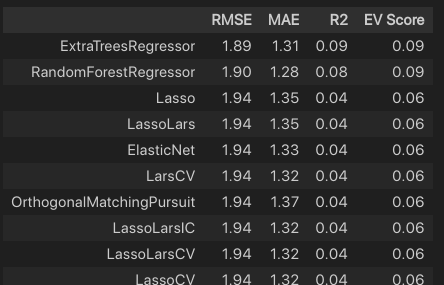

In [23]:
n_estimator_list = [80, 100, 150, 250, 400, 450, 500, 600, 750, 1000]

for n_estimators in n_estimator_list:
    extra_trees_default = ensemble.ExtraTreesRegressor(random_state=42, n_estimators=n_estimators)
    extra_trees_default.fit(X_train, y_train[:,1])

    y_pred = extra_trees_default.predict(X_test)

    print(f'{n_estimators}, RMSE, R2: {np.sqrt(mean_squared_error(y_test[:,1], y_pred)):.2f}, {r2_score(y_test[:,1], y_pred)}')

80, RMSE, R2: 1.90, 0.08131824992385994
100, RMSE, R2: 1.89, 0.08690999868520599
150, RMSE, R2: 1.90, 0.0806226059361912
250, RMSE, R2: 1.89, 0.08898545760303445
400, RMSE, R2: 1.90, 0.0761303548328679
450, RMSE, R2: 1.90, 0.07437435282876748
500, RMSE, R2: 1.90, 0.0745478852179049
600, RMSE, R2: 1.91, 0.07031757980856046
750, RMSE, R2: 1.91, 0.07000572969827923
1000, RMSE, R2: 1.90, 0.07285188038049084


In [24]:
### Collection_ratio,
extra_trees_params = {
    'n_estimators': [100, 200,250, 500, 1000],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,1])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'r2': r2_score(y_test[:,1], y_pred),
        'msle': mean_squared_log_error(y_test[:,1], y_pred)
    })

scores_df = pd.DataFrame(scores)

100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


In [26]:
scores_df.sort_values(by='r2', ascending=False).head(5)

,params,rmse,r2,msle
9,"{'max_depth': None, 'max_features': None, 'min...",1.88,0.10,0.22
30,"{'max_depth': 5, 'max_features': None, 'min_sa...",1.88,0.10,0.21
8,"{'max_depth': None, 'max_features': None, 'min...",1.88,0.10,0.22
34,"{'max_depth': 5, 'max_features': None, 'min_sa...",1.88,0.10,0.21
32,"{'max_depth': 5, 'max_features': None, 'min_sa...",1.88,0.10,0.21


In [27]:
for param in scores_df.sort_values(by='r2', ascending=False).head(5).params:
    print(param)

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250, 'random_state': 42}


In [28]:
### Collection_ratio, extra trees, v2
extra_trees_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1,2,5],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,1])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,1], y_pred)),
        'r2': r2_score(y_test[:,1], y_pred),
        'msle': mean_squared_log_error(y_test[:,1], y_pred)
    })

scores_df = pd.DataFrame(scores)

100%|██████████| 36/36 [00:18<00:00,  1.96it/s]


In [29]:
scores_df.sort_values(by='r2', ascending=False).head(5)

,params,rmse,r2,msle
5,"{'max_depth': None, 'max_features': None, 'min...",1.88,0.10,0.22
24,"{'max_depth': 5, 'max_features': None, 'min_sa...",1.88,0.10,0.21
4,"{'max_depth': None, 'max_features': None, 'min...",1.88,0.10,0.22
26,"{'max_depth': 5, 'max_features': None, 'min_sa...",1.88,0.10,0.21
29,"{'max_depth': 5, 'max_features': None, 'min_sa...",1.88,0.10,0.21


In [30]:
for param in scores_df.sort_values(by='r2', ascending=False).head(5).params:
    print(param)

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}


In [31]:
extra_trees_best_params = scores_df.sort_values(by='r2', ascending=False).reset_index(drop=True).params[0]
extra_trees_best_params

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000,
 'random_state': 42}

In [32]:
extra_trees_best = ensemble.ExtraTreesRegressor(**extra_trees_best_params)
extra_trees_best.fit(X_train, y_train[:,1])


ExtraTreesRegressor(max_features=None, min_samples_split=5, n_estimators=1000,
                    random_state=42)

In [33]:
joblib.dump(extra_trees_best, '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_success_engagement/domain_engagement/collection_ratio.pkl')

['/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_engagement/collection_ratio.pkl']

### Number of Backers

In [36]:
n_estimator_list = [100,500, 1000, 2000]

for n_estimators in n_estimator_list:
    extra_trees_default = ensemble.ExtraTreesRegressor(random_state=42, n_estimators=n_estimators)
    extra_trees_default.fit(X_train, y_train[:,2])

    y_pred = extra_trees_default.predict(X_test)

    print(f'{n_estimators}, RMSE, R2: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.2f}, {r2_score(y_test[:,2], y_pred)}')

100, RMSE, R2: 3617.77, 0.32177707742049544
500, RMSE, R2: 3592.24, 0.33131624029169526
1000, RMSE, R2: 3589.57, 0.3323099613059858
2000, RMSE, R2: 3587.19, 0.3331962278579752


In [37]:
n_estimator_list = [2000, 1500, 1000]

for n_estimators in n_estimator_list:
    extra_trees_default = ensemble.ExtraTreesRegressor(random_state=42, n_estimators=n_estimators)
    extra_trees_default.fit(X_train, y_train[:,2])

    y_pred = extra_trees_default.predict(X_test)

    print(f'{n_estimators}, RMSE, R2: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.2f}, {r2_score(y_test[:,2], y_pred)}')

2000, RMSE, R2: 3587.19, 0.3331962278579752
1500, RMSE, R2: 3588.34, 0.33276650567720567
1000, RMSE, R2: 3589.57, 0.3323099613059858


In [38]:
### Collection_ratio,
extra_trees_params = {
    'n_estimators': [1000,2000, 100 ],
    'max_depth': [None],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}


scores = []
for param in tqdm(ParameterGrid(extra_trees_params)):
    extra_trees_regressor = ensemble.ExtraTreesRegressor(**param)
    extra_trees_regressor.fit(X_train, y_train[:,2])

    y_pred = extra_trees_regressor.predict(X_test)
    scores.append({
        'params': param,
        'rmse': np.sqrt(mean_squared_error(y_test[:,2], y_pred)),
        'r2': r2_score(y_test[:,2], y_pred),
        'msle': mean_squared_log_error(y_test[:,2], y_pred)
    })

scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='r2', ascending=False)

100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


,params,rmse,r2,msle
1,"{'max_depth': None, 'max_features': None, 'min...",3587.19,0.33,1.05
0,"{'max_depth': None, 'max_features': None, 'min...",3589.57,0.33,1.04
2,"{'max_depth': None, 'max_features': None, 'min...",3617.77,0.32,1.02
4,"{'max_depth': None, 'max_features': None, 'min...",3621.66,0.32,1.03
3,"{'max_depth': None, 'max_features': None, 'min...",3631.66,0.32,1.03
5,"{'max_depth': None, 'max_features': None, 'min...",3637.90,0.31,1.04
6,"{'max_depth': None, 'max_features': None, 'min...",3641.29,0.31,1.00
7,"{'max_depth': None, 'max_features': None, 'min...",3643.31,0.31,1.01
8,"{'max_depth': None, 'max_features': None, 'min...",3648.46,0.31,1.00
17,"{'max_depth': None, 'max_features': None, 'min...",3812.56,0.25,1.01


In [40]:
extra_trees_best_params = scores_df.sort_values(by='r2', ascending=False).reset_index(drop=True).params[0]

extra_trees_best = ensemble.ExtraTreesRegressor(**extra_trees_best_params)
extra_trees_best.fit(X_train, y_train[:,2])

joblib.dump(extra_trees_best, '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_success_engagement/domain_engagement/num_backers.pkl')

['/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_engagement/num_backers.pkl']

### Success

In [44]:
n_estimator_list = [75, 100, 500, 1000, 2000]

for n_estimators in n_estimator_list:
    balanced_rf = BalancedRandomForestClassifier(random_state=42, n_estimators=n_estimators)
    balanced_rf.fit(X_train, y_train[:,0])

    y_pred = balanced_rf.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')
    print(classification_report(y_test[:,0], y_pred))

Accuracy: 0.6363636363636364
              precision    recall  f1-score   support

         0.0       0.15      0.55      0.23        11
         1.0       0.93      0.65      0.76        99

    accuracy                           0.64       110
   macro avg       0.54      0.60      0.50       110
weighted avg       0.85      0.64      0.71       110

Accuracy: 0.6363636363636364
              precision    recall  f1-score   support

         0.0       0.15      0.55      0.23        11
         1.0       0.93      0.65      0.76        99

    accuracy                           0.64       110
   macro avg       0.54      0.60      0.50       110
weighted avg       0.85      0.64      0.71       110

Accuracy: 0.6636363636363637
              precision    recall  f1-score   support

         0.0       0.16      0.55      0.24        11
         1.0       0.93      0.68      0.78        99

    accuracy                           0.66       110
   macro avg       0.54      0.61      0.

In [45]:
balanced_rf_params = {
    'n_estimators': [100, 500,1000],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'random_state': [42]
}

scores = []

for param in tqdm(ParameterGrid(balanced_rf_params)):
    easytrees = BalancedRandomForestClassifier(**param)
    easytrees.fit(X_train, y_train[:,0])

    y_pred = easytrees.predict(X_test)

    accuracy = accuracy_score(y_test[:,0], y_pred)
    precision = precision_score(y_test[:,0], y_pred)
    recall = recall_score(y_test[:,0], y_pred)
    f1 = f1_score(y_test[:,0], y_pred)
    roc_auc = roc_auc_score(y_test[:,0], y_pred)

    confusion_matrix = metrics.confusion_matrix(
        y_test[:,0], y_pred)
    
    #class_wise acc
    class_wise_acc = {}
    for i in range(2):
        class_wise_acc[i] = confusion_matrix[i][i] / sum(confusion_matrix[i])
    


    class_wise_acc_list = [class_wise_acc[i] for i in range(2)] 

    scores.append([param,
        accuracy, precision, recall, f1, roc_auc,
        ] + class_wise_acc_list)

scores_df = pd.DataFrame(scores)
scores_df.columns = ['params', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'class_0_acc', 'class_1_acc']

100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


In [47]:
scores_df.sort_values(by=['class_0_acc', 'f1','class_1_acc'], ascending=False).head(5)

,params,accuracy,precision,recall,f1,roc_auc,class_0_acc,class_1_acc
3,"{'max_depth': None, 'max_features': None, 'min...",0.72,0.94,0.74,0.82,0.64,0.55,0.74
7,"{'max_depth': None, 'max_features': None, 'min...",0.72,0.94,0.74,0.82,0.64,0.55,0.74
10,"{'max_depth': None, 'max_features': None, 'min...",0.72,0.94,0.74,0.82,0.64,0.55,0.74
15,"{'max_depth': None, 'max_features': None, 'min...",0.72,0.94,0.74,0.82,0.64,0.55,0.74
0,"{'max_depth': None, 'max_features': None, 'min...",0.71,0.94,0.73,0.82,0.64,0.55,0.73


In [48]:
balanced_rf_best_params = scores_df.params[0]

balanced_rf_best = BalancedRandomForestClassifier(**balanced_rf_best_params)
balanced_rf_best.fit(X_train, y_train[:,0])


BalancedRandomForestClassifier(max_features=None, random_state=42)

In [49]:

joblib.dump(balanced_rf_best, '/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_success_engagement/domain_engagement/success.pkl')

['/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_engagement/success.pkl']